# Excercise NN/01 - Neural Networks

Contact: Dr. David C. Schedl <br/>
E-Mail: david.schedl@fh-hagenberg.at <br/>
Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Backpropagation and NNs**.

*Acknowledgements:*
This notebook is strongly inspired by the NN-zero-to-here lecture series of Andrej Karpathy, available [here](https://github.com/karpathy/nn-zero-to-hero).

## Setup
As first step, we need to import the necessary libraries. 

In [4]:
# Setup and import of libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Computing Gradients
Let's start simple with the quadratic function $f(x) = 3x^2 - 4x + 5$.

In [5]:
def f(x):
  return 3*x**2 - 4*x + 5

Let's plot it in the range $[-5, 5]$.

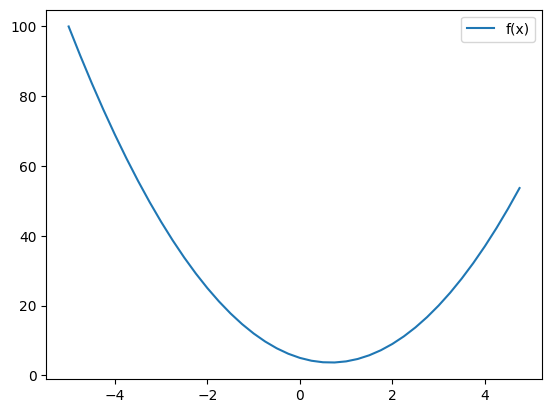

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, label='f(x)')
plt.legend(); plt.show()

The derivative of this function is $\frac{df(x)}{dx} = 6x - 4$.

The minimum ($0 = \frac{df(x)}{dx}$) is at $x = \frac{4}{6} = \frac{2}{3}$.

Let's numerically derive the function and let's look at some values. 

In [7]:
h = 0.000001
x = 2/3 # test with -4, 0, 2/3 and 4
(f(x + h) - f(x))/h

2.999378523327323e-06

🤔 Can you also derive $df(x)/df$?

## Simple Gradient Descent

With the gradient we can now implement a simple gradient descent algorithm, which iteratively updates the value of $x$ in the direction of the negative gradient.
The parameters are the learning rate (often denoted as $\alpha$) and the number of iterations $N$.

🤔 What happens if you change the learning rate or the number of iterations?

x' reached: 0.6661768312361573 after 10 iterations and should be 2/3!


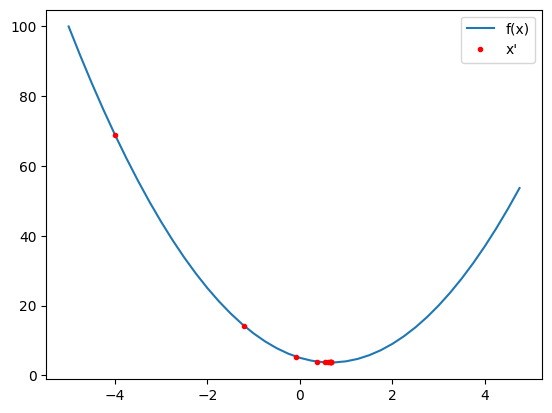

In [8]:
# simple gradient descent

x = -4
_xs = [x]
learning_rate = 0.1
N = 10 # number of iterations
for i in range(N):
    df = (f(x + h) - f(x))/h
    x = x - learning_rate * df
    _xs.append(x)

print(f"x' reached: {x} after {N} iterations and should be 2/3!")
plt.plot(xs, ys, label='f(x)') # plot the function
plt.plot(_xs, f(np.array(_xs)), 'r.', label='x\'') # plot the path our gradient descent took
plt.legend(); plt.show()

## More Complex Functions
An example with a more complex function and multiple parameters:
$f(x, y, z) = (x + y) * z$. <br>
This example with the exact same parameters is used on the slides: 
$ x = -2, y = 5, z = -4$.

In [9]:
# let's get more complex
x = -2.0
y = 5.0
z = -4.0
def f(x,y,z): 
    return (x+y)*z
print(f(x,y,z))

-12.0


The function has three parameters ($x,y,z$) and therefore multiple gradients are computed: $\frac{df(x,y,z)}{dx}, \frac{df(x,y,z)}{dy}, \frac{df(x,y,z)}{dz}$.

In [10]:
h = 0.0001

# inputs
x = -2.0
y = 5.0
z = -4.0

f1 = f(x,y,z)
f2 = f(x,y,z)+h # slope -> ~  1
# f2 = f(x+h,y,z) # slope -> ~ -4
# f2 = f(x,y+h,z) # slope -> ~ -4
# f2 = f(x,y,z+h) # slope -> ~  3

print('f1', f1)
print('f2', f2)
print('slope', (f2 - f1)/h)


f1 -12.0
f2 -11.9999
slope 0.9999999999976694


# Task 1 📝: Derivative on sheet and paper

Hand in a sheet/picture showing the manual derivative of the equation above: $f(x, y, z) = (x + y) * z$.

What are the analytical gradients of $f(x,y,z)$ with respect to $x, y, z$ ($\frac{df(x,y,z)}{dx}, \frac{df(x,y,z)}{dy}, \frac{df(x,y,z)}{dz}$)?

Verify your results by comparing it to the numerical gradients (above).

# Towards Backpropagation
This is where the magic will happen ... ✨ <br>

## The Value class
First we'll implement a Value class that will help us to keep track of the compute graph, values and gradients.

In [11]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
       
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
      
    return out

# a quick working example
print(Value(1) + Value(4))
print(Value(2) * Value(3))

Value(data=5)
Value(data=6)


### Visualization Helpers

The following functions will help us to visualize the compute graph.

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%sdata %.2f | grad %.2f}" % (f"{n.label} |" if n.label else '', n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


# Let's visualize a very simple example
x = Value(1.0)
y = (x * 2 + 1).tanh()
draw_dot(y)
# ignore grad for now!!!

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Let's use the example from above
An example with a more complex function and multiple parameters:
$f(x, y, z) = (x + y) * z$. <br>
This example with the exact same parameters is used on the slides: 
$ x = -2, y = 5, z = -4$.

In [13]:
x = Value(-2.0); x.label='x'
y = Value(5); y.label='y'
z = Value(-4.0); z.label='z'

q = x + y; q.label = 'q (x+y)'
o = q*z; o.label='o'

# gradients
o.grad = 1.0
q.grad = -4.0
x.grad = -4.0
y.grad = -4.0
z.grad = 3.0

draw_dot(o)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Task 2 📝: Backprop on sheet and paper

Hand in a picture (hand-drawn or digitally with the code below) showing the gradients for the example below. Document your steps how you got to your result. <br>

The example will be different for each student as the random values are different. Enter your birthdate (`d, m, y`) in the code below to get individual values.


In [14]:
# enter your birthday here (will be used to generate random numbers)
d, m, y = 29, 2, 1980

# init the random number generator
import random
random.seed(d+m+y); r_range = (1, 9)

x1 = Value(random.randint(*r_range)); x1.label='x1'
x2 = Value(random.randint(*r_range)); x2.label='x2'
x3 = Value(random.randint(*r_range)); x3.label='x3'
w1 = Value(random.randint(*r_range)); w1.label='w1'
w2 = Value(random.randint(*r_range)); w2.label='w2'
w3 = Value(random.randint(*r_range)); w3.label='w3'
b = Value(random.randint(*r_range));  b.label='b'

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x3w3 = x3*w3; x3w3.label='x3w3'
sums = (x1w1 + x2w2) + (x3w3 + b); sums.label='sum'
o = sums * Value(0.25); o.label='o'
o.label='o'
draw_dot(o)

# Todo: what are the gradients?
# o.grad = 1.0 ... and so on


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH